In [1]:
import numpy as np
# load WRDS OptionMetrics data from csv
data = np.loadtxt("options_data.csv", dtype=str, delimiter=',', usecols=(0, 1, 2, 3, 4, 5, 6, 7, 8, 12))
print(data[0])


['date' 'exdate' 'cp_flag' 'strike_price' 'best_bid' 'best_offer' 'volume'
 'open_interest' 'impl_volatility' 'issuer']


In [2]:
from datetime import datetime

# create a sorted list of all dates in the option data
dates = set()
for option in data:
    if option[0] not in dates:
        if option[0] != 'date':
            dates.add(option[0])
            dates.add(option[1])
date_list = []
for date in dates:
    date_list.append(date)
    
date_list = (sorted(date_list, key=lambda x: datetime.strptime(x, '%Y-%m-%d')) )


In [3]:
# create a list of all Duke Energy options
duke_options = []

for option in data:
    # skip options with no volume
    if option[6] == '0':
        continue
    if option[-1] == 'DUKE ENERGY CORP.':
        duke_options.append(option.tolist())

In [5]:
# make dictionary with keys of the following form:
# (expiration date, 'C'/'P', strike*1000)
def make_option_dict(options):
    option_dict = {}
    for option in options:
        key = (option[1], option[2], int(option[3]))
        if key in option_dict:
            option_dict[key].append(option)
        else:
            option_dict[key] = [option]
    for key in option_dict.keys():
        option_dict[key] = sorted(option_dict[key], key=lambda x: datetime.strptime(x[0], '%Y-%m-%d'))
    return option_dict

In [6]:
duke_dict = make_option_dict(duke_options)

In [12]:
import scipy
import matplotlib.pyplot as plt

# From Math86 Problem Set 3
# Calculate implied volatility of a call with Newton's method
def implied_vol_call(call_price, K, T, S, R, error):
    # initial guess of 0.4 for volatility
    vol = 0.4
    dv = error + 1
    # add counter to prevent infinite loops when not converging
    i = 0
    # use Newton's method to find the IV
    while abs(dv) > error and i < 5000:
        d1 = (np.log(S) - np.log(K) + (R + (vol**2)/2) * T) / ( vol * (T**0.5) )
        d2 = d1 - vol*(T**0.5)
        price_error = S * scipy.stats.norm.cdf(d1) - K * np.exp(-R * T) * scipy.stats.norm.cdf(d2) - call_price
        vega = S * ( (T/(2*np.pi) )**0.5 ) * np.exp(- (d1**2) / 2)
        dv = price_error / vega
        vol = vol - dv
        i += 1
    return vol

# calculate implied volatility of a put using Newton's method
def implied_vol_put(put_price, K, T, S, R, error):
    # initial guess of 0.4 for volatility
    vol = 0.4
    dv = error + 1
    # add counter to prevent infinite loops when not converging
    i = 0
    # use Newton's method to find the IV
    while abs(dv) > error and i < 5000:
        d1 = (np.log(S) - np.log(K) + (R + (vol**2)/2) * T) / ( vol * (T**0.5) )
        d2 = d1 - vol*(T**0.5)
        price_error = K * np.exp(-R * T) * scipy.stats.norm.cdf(-d2) - S * scipy.stats.norm.cdf(-d1) - put_price
        vega = S * ( (T/(2*np.pi) )**0.5 ) * np.exp(- (d1**2) / 2)
        dv = price_error / vega
        vol = vol - dv
        i += 1
    return vol

In [8]:
# return a list of options from a dictionary with a given expiration date
def get_options_by_exp(exp_date, option_dict):
    options = []
    for key in option_dict.keys():
        exp, cp, strike = key
        if exp == exp_date:
            options.append(option_dict[key])
    return options

In [9]:
# return strikes and implied volatilities for options in a dictionary for a given expiration date, current date,
# spot price, time to expiry, and risk-free rate
def get_smiles(expire_date, curr_date, S, T, R, option_dict):
    curr_options = get_options_by_exp(expire_date, option_dict)
    put_smile = []
    call_smile = []
    for opt in curr_options:
        # calculate the implied volatility of each option on the current date
        for day in opt:
            if day[0] == curr_date:
                if day[2] == 'C':
                    # use mid prices
                    call_price = ( float(day[4]) + float(day[5]) ) / 2
                    if day[8] == '':
                        iv = implied_vol_call(call_price, float(day[3])/1000, T/252, S, R, 0.01)
                    else:
                        iv = implied_vol_call(call_price, float(day[3])/1000, T/252, S, R, 0.01)
                    call_smile.append([float(day[3])/1000, iv])
                elif day[2] == 'P':
                    put_price = ( float(day[4]) + float(day[5]) ) / 2
                    if day[8] == '':
                        iv = implied_vol_put(put_price, float(day[3])/1000, T/252, S, R, 0.01)
                    else:
                        iv = implied_vol_put(put_price, float(day[3])/1000, T/252, S, R, 0.01)
                    put_smile.append([float(day[3])/1000, iv])
                

    call_smile = sorted(call_smile, key=lambda x: x[0])
    call_strikes = []
    call_ivs = []
    for call in call_smile:
        if call[0] > S:
            call_strikes.append(call[0])
            call_ivs.append(call[1])
        
    put_smile = sorted(put_smile, key=lambda x: x[0])
    put_strikes = []
    put_ivs = []
    for put in put_smile:
        if put[0] < S:
            put_strikes.append(put[0])
            put_ivs.append(put[1])
    strikes = put_strikes + call_strikes
    ivs = put_ivs + call_ivs
    return strikes, ivs

In [10]:
# return an existing option expiration date within between 10 and 45 business days of a given date
def near_exp(date, option_dict):
    for key in option_dict.keys():
        exp_date , __, __ = key
        if np.busday_count(date, exp_date) < 45 and np.busday_count(date, exp_date) > 10:
            return exp_date

C:\Users\wbalk\AppData\Local\Temp\ipykernel_10504\1087085969.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  dv = price_error / vega
C:\Users\wbalk\AppData\Local\Temp\ipykernel_10504\1087085969.py:14: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S) - np.log(K) + (R + (vol**2)/2) * T) / ( vol * (T**0.5) )
C:\Users\wbalk\AppData\Local\Temp\ipykernel_10504\1087085969.py:14: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S) - np.log(K) + (R + (vol**2)/2) * T) / ( vol * (T**0.5) )


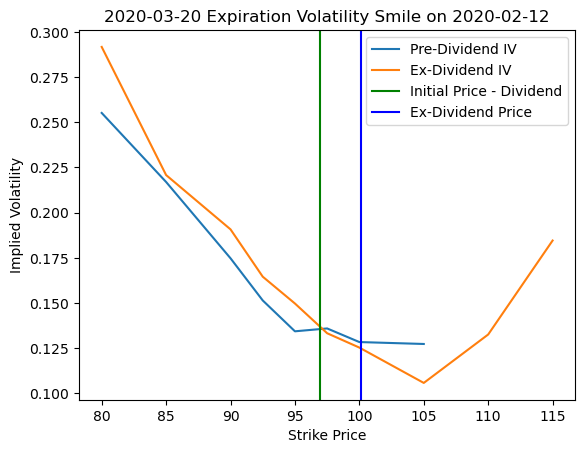

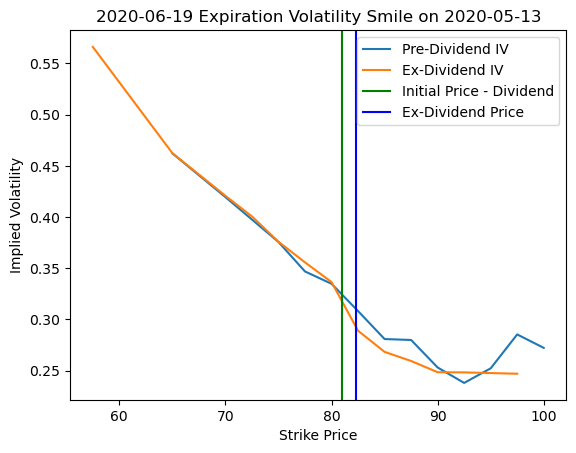

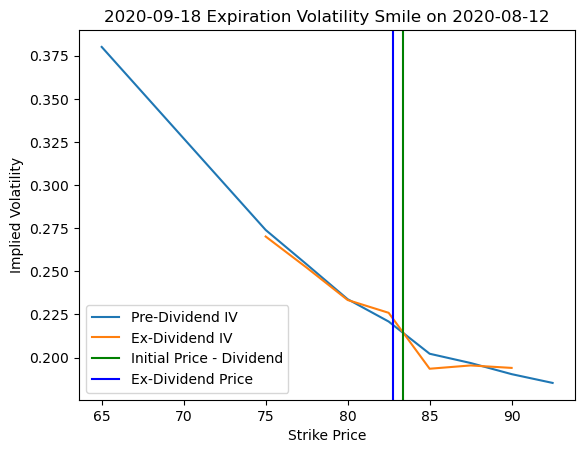

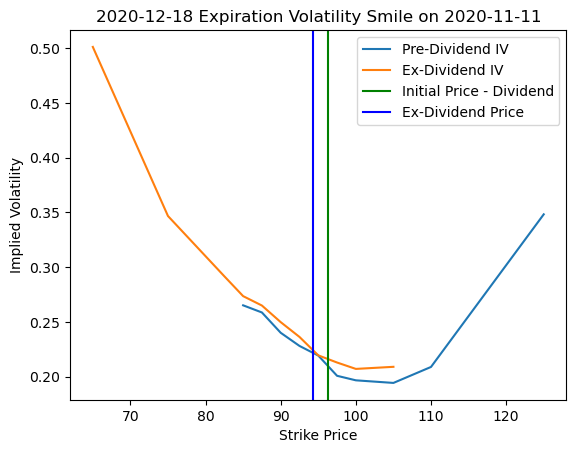

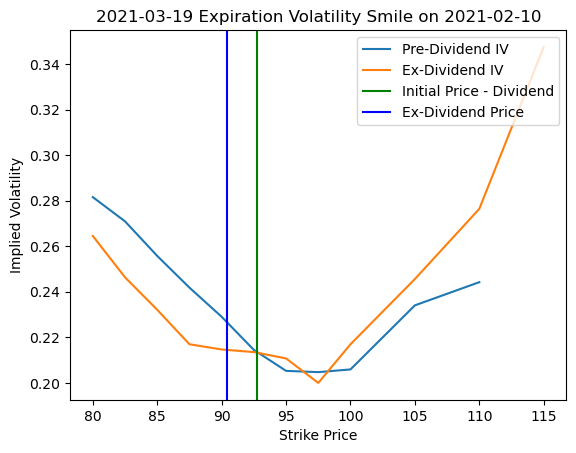

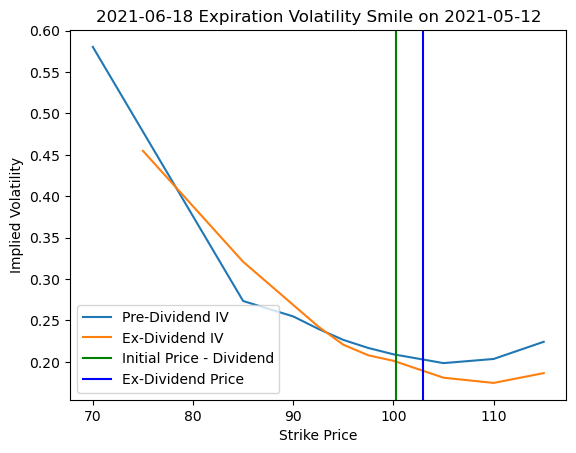

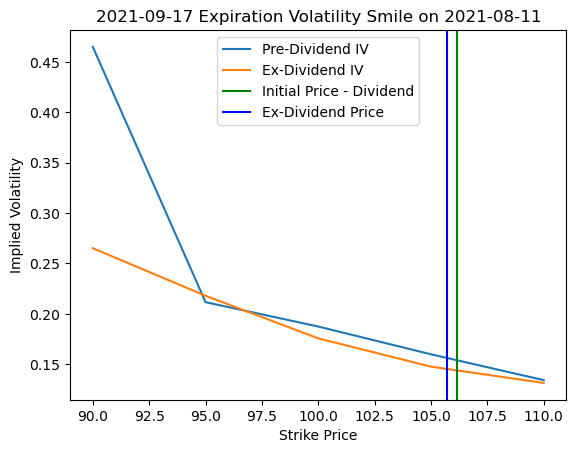

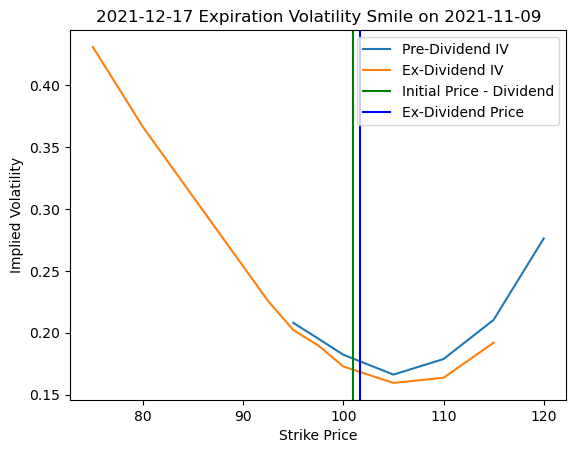

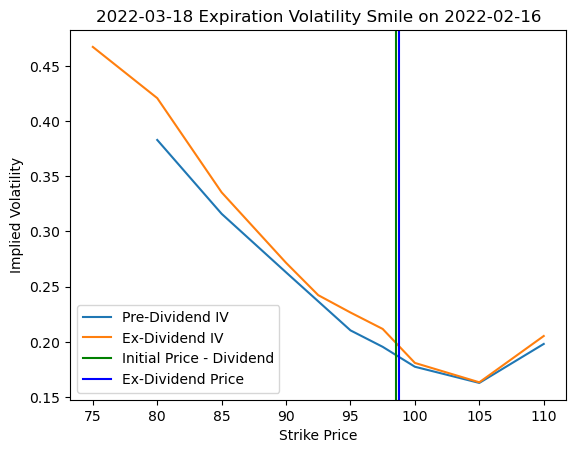

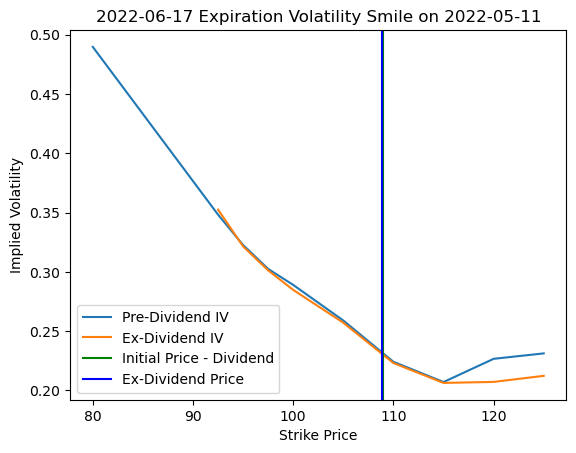

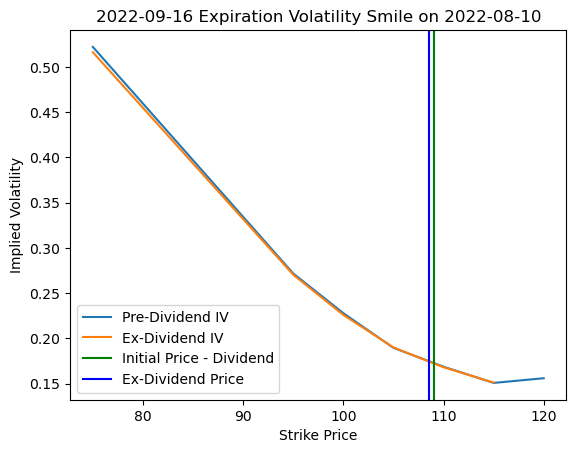

<Figure size 640x480 with 0 Axes>

In [16]:
# ex-dividend, pre-dividend dates and prices for Duke Energy, as well as dividend value
dates_prices = [
    ('2020-02-13', '2020-02-12', 100.11, 97.92, 0.945),
    ('2020-05-14', '2020-05-13', 82.30, 81.89, 0.945),
    ('2020-08-13', '2020-08-12', 82.74, 84.32, 0.965),
    ('2020-11-12', '2020-11-11', 94.25, 97.31, 0.965),
    ('2021-02-11', '2021-02-10', 90.42, 93.70, 0.965),
    ('2021-05-13', '2021-05-12', 103.00, 101.22, 0.965),
    ('2021-08-12', '2021-08-11', 105.69, 107.14, 0.985),
    ('2021-11-10', '2021-11-09', 101.62, 101.96, 0.985),
    ('2022-02-17', '2022-02-16', 98.73, 99.51, 0.985),
    ('2022-05-12', '2022-05-11', 108.85, 109.91, 0.985),
    ('2022-08-11', '2022-08-10', 108.51, 110.06, 1.005)
    
]


for div in dates_prices:
    ex_date, pre_date, ex_price, pre_price, div_value= div
    exp_date = near_exp(ex_date, duke_dict)
    T = np.busday_count(pre_date, exp_date)

    pre_strike, pre_iv = get_smiles(exp_date, pre_date, pre_price - div_value, T, 0.0158, duke_dict)
    ex_strike, ex_iv = get_smiles(exp_date, ex_date, ex_price, T, 0.0158, duke_dict)
    plt.plot(pre_strike, pre_iv, label="Pre-Dividend IV")
    plt.plot(ex_strike, ex_iv, label="Ex-Dividend IV")
   
    plt.title(exp_date + " Expiration Volatility Smile on " + pre_date)
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    
    plt.axvline(x = pre_price - div_value, color="g", label="Initial Price - Dividend")
    plt.axvline(x = ex_price, color="b", label="Ex-Dividend Price")
    plt.legend()
    plt.figure()
    

In [17]:
# black scholes prices. options include no more dividends until expiry
def bs_price_call(F, K, R, vol, T):
    d1 = ( np.log(F) - np.log(K) ) / (vol * (T**0.5) ) + (vol * (T ** 0.5) ) /2 
    d2 = d1 - vol*(T**0.5)
    price = np.exp(-R * T) * ( F * scipy.stats.norm.cdf(d1) - K *  scipy.stats.norm.cdf(d2) )
    return price

def bs_price_put(F, K, R, vol, T):
    call = bs_price_call(F, K, R, vol, T)
    price = call - np.exp(-R * T) * (F - K)
    return price

In [19]:
# Example verifying that sigma portfolio option retains same value before and after dividend
S = 50
E = 50
R = 0.05
T = 30
vol = 0.4
D = 10
Td = 15


F = np.exp(Td*R) * (S*np.exp(Td * R) - D)
lmbda = 1 + D / (S * np.exp(Td * R) - D)
print("Price before dividend:", bs_price_call(S * np.exp(R * T), E, R, vol, T))
print("Price after dividend:", lmbda * bs_price_call(F, E/lmbda, R, vol, T))

Price before dividend: 44.3234564275554
Price after dividend: 44.32345642755541


C:\Users\wbalk\AppData\Local\Temp\ipykernel_20032\1349565906.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  dv = price_error / vega
C:\Users\wbalk\AppData\Local\Temp\ipykernel_20032\1349565906.py:13: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S) - np.log(K) + (R + (vol**2)/2) * T) / ( vol * (T**0.5) )
C:\Users\wbalk\AppData\Local\Temp\ipykernel_20032\1349565906.py:13: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S) - np.log(K) + (R + (vol**2)/2) * T) / ( vol * (T**0.5) )


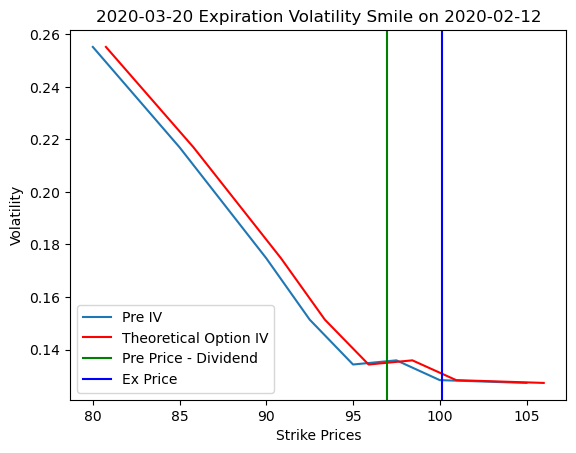

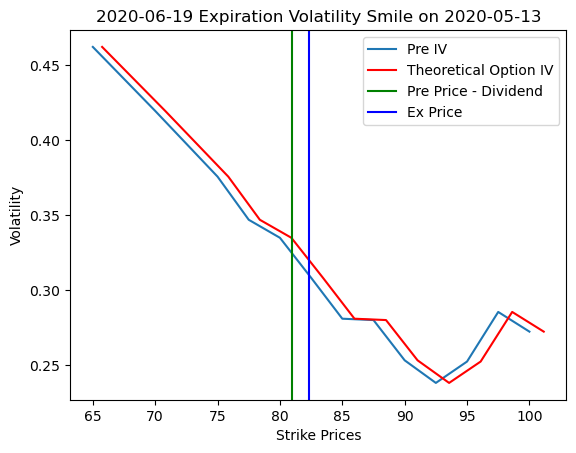

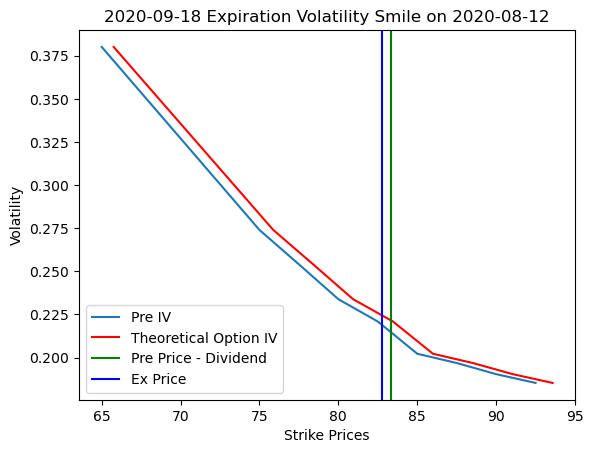

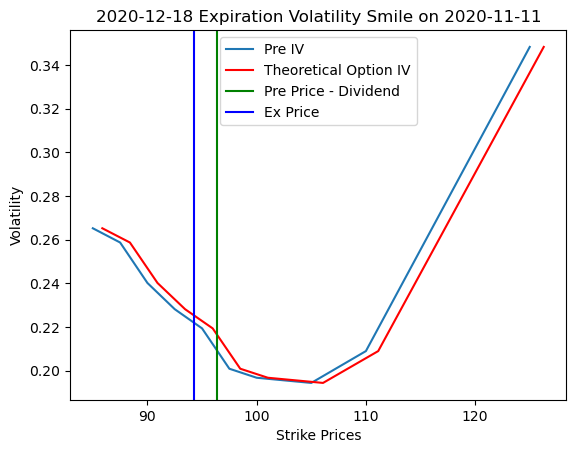

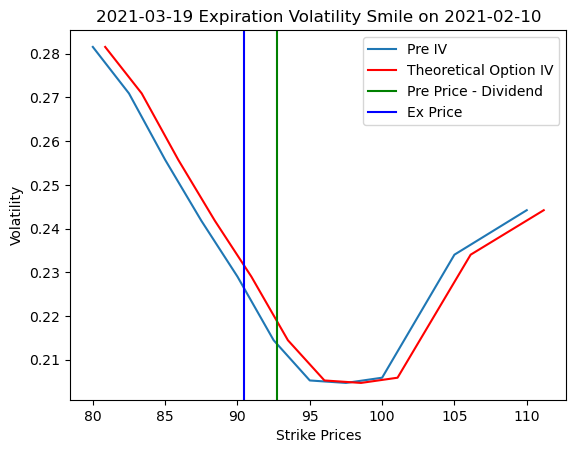

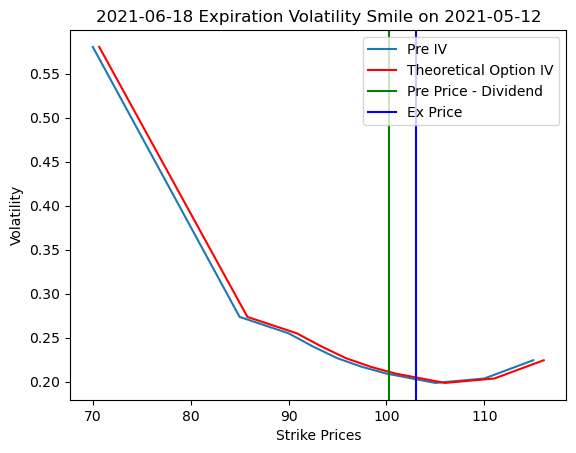

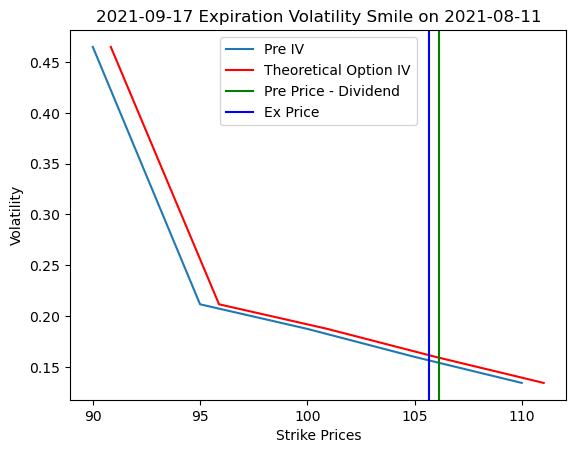

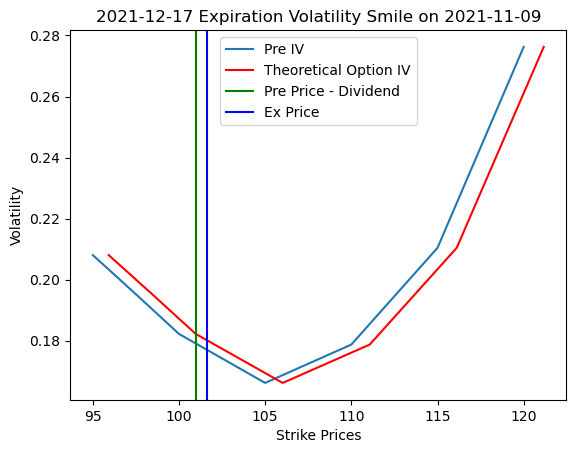

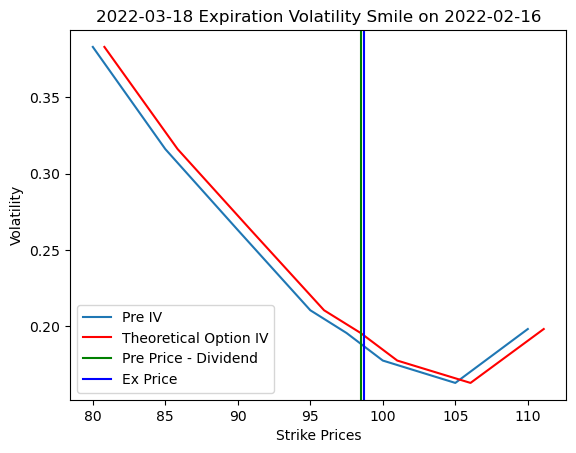

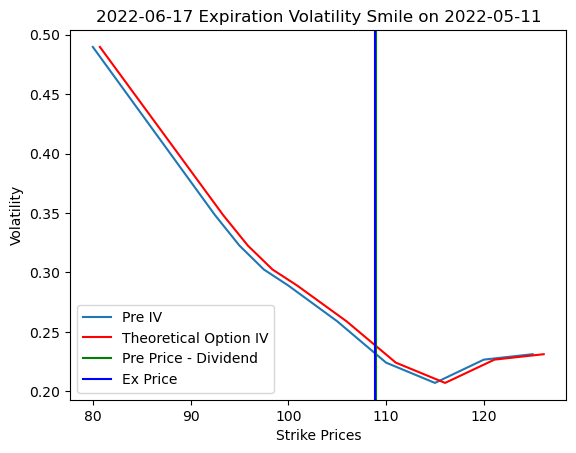

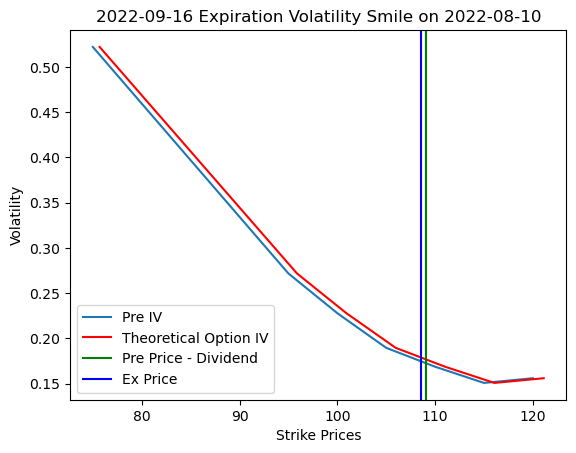

<Figure size 640x480 with 0 Axes>

In [303]:
# plot pre-dividend smiles again along with sigma portfolio option's smiles
for div in dates_prices:
    ex_date, pre_date, ex_price, pre_price, div_amount = div
    exp_date = near_exp(ex_date, duke_dict)
    T = np.busday_count(pre_date, exp_date)
    
    pre_strike, pre_iv = get_smiles(exp_date, pre_date, pre_price - div_amount, T, 0.0158, duke_dict)
    ex_strike, ex_iv = get_smiles(exp_date, ex_date, ex_price, T, 0.0158, duke_dict)
    plt.plot(pre_strike, pre_iv, label="Pre IV")
    
    lmbda = 1 + ( div_amount / ex_price )
    
    pre_scaled_strike = []
    for strike in pre_strike:
        pre_scaled_strike.append(strike * lmbda)
    plt.plot(pre_scaled_strike, pre_iv, label="Theoretical Option IV", color="r")
   
    plt.title(exp_date + " Expiration Volatility Smile on " + pre_date)
    plt.xlabel("Strike Prices")
    plt.ylabel("Volatility")
    plt.axvline(x = pre_price-div_amount, color="g", label="Pre Price - Dividend")
    plt.axvline(x = ex_price, color="b", label="Ex Price")
    plt.legend()
    plt.figure()

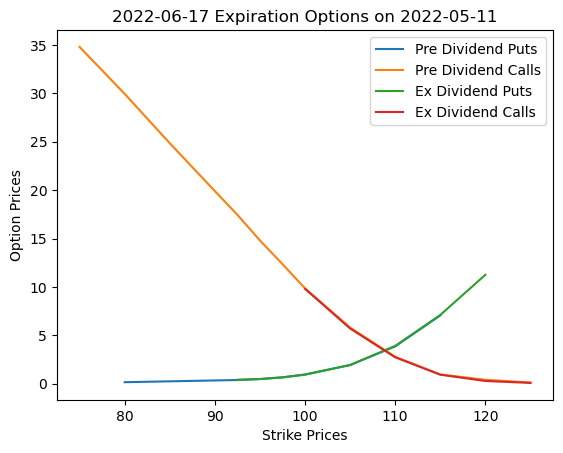

In [302]:
# Plot prices on calls and puts before and after a dividend
options = get_options_by_exp('2022-06-17', duke_dict)
# '2022-05-11' and '2022-05-12'
pre_puts = []
pre_calls = []
ex_puts = []
ex_calls = []
for option in options:
    for day in option:
        if day[0] == '2022-05-11':
            if day[2] == 'C':
                pre_calls.append((float(day[3])/1000, (float(day[4]) + float(day[5]))/2))
            elif day[2] == 'P':
                pre_puts.append((float(day[3])/1000, (float(day[4]) + float(day[5]))/2))
        if day[0] == '2022-05-12':
            if day[2] == 'C':
                ex_calls.append((float(day[3])/1000, (float(day[4]) + float(day[5]))/2))
            elif day[2] == 'P':
                ex_puts.append((float(day[3])/1000, (float(day[4]) + float(day[5]))/2))
                
pre_puts = sorted(pre_puts, key = lambda x: x[0])
pre_calls = sorted(pre_calls, key = lambda x: x[0])
ex_puts = sorted(ex_puts, key = lambda x: x[0])
ex_calls = sorted(ex_calls, key = lambda x: x[0])

pre_put_strikes, pre_put_prices = zip(*pre_puts)
pre_call_strikes, pre_call_prices = zip(*pre_calls)
ex_put_strikes, ex_put_prices = zip(*ex_puts)
ex_call_strikes, ex_call_prices = zip(*ex_calls)

plt.plot(pre_put_strikes, pre_put_prices, label="Pre Dividend Puts")
plt.plot(pre_call_strikes, pre_call_prices, label="Pre Dividend Calls")
plt.plot(ex_put_strikes, ex_put_prices, label="Ex Dividend Puts")
plt.plot(ex_call_strikes, ex_call_prices, label="Ex Dividend Calls")
plt.xlabel("Strike Prices")
plt.ylabel("Option Prices")
plt.title("2022-06-17 Expiration Options on 2022-05-11")
plt.legend()